In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Function definitions

In [2]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(18,18))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

# Reading in data

In [3]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = reduce_memory(df) # converts float64 to float32

100%|██████████| 24/24 [00:00<00:00, 367.07it/s]

Memory uasge reduced from 0.022 GB to 0.012 GB
CPU times: user 2.3 s, sys: 163 ms, total: 2.46 s
Wall time: 583 ms


# Resample data

In [15]:
day = resample_df(df,'1H')
day = day.dropna()

100%|██████████| 52/52 [00:00<00:00, 116.34it/s]


# EDA on daily mean data

Saving heatmap
CPU times: user 482 ms, sys: 20.1 ms, total: 502 ms
Wall time: 502 ms


<Figure size 432x288 with 0 Axes>

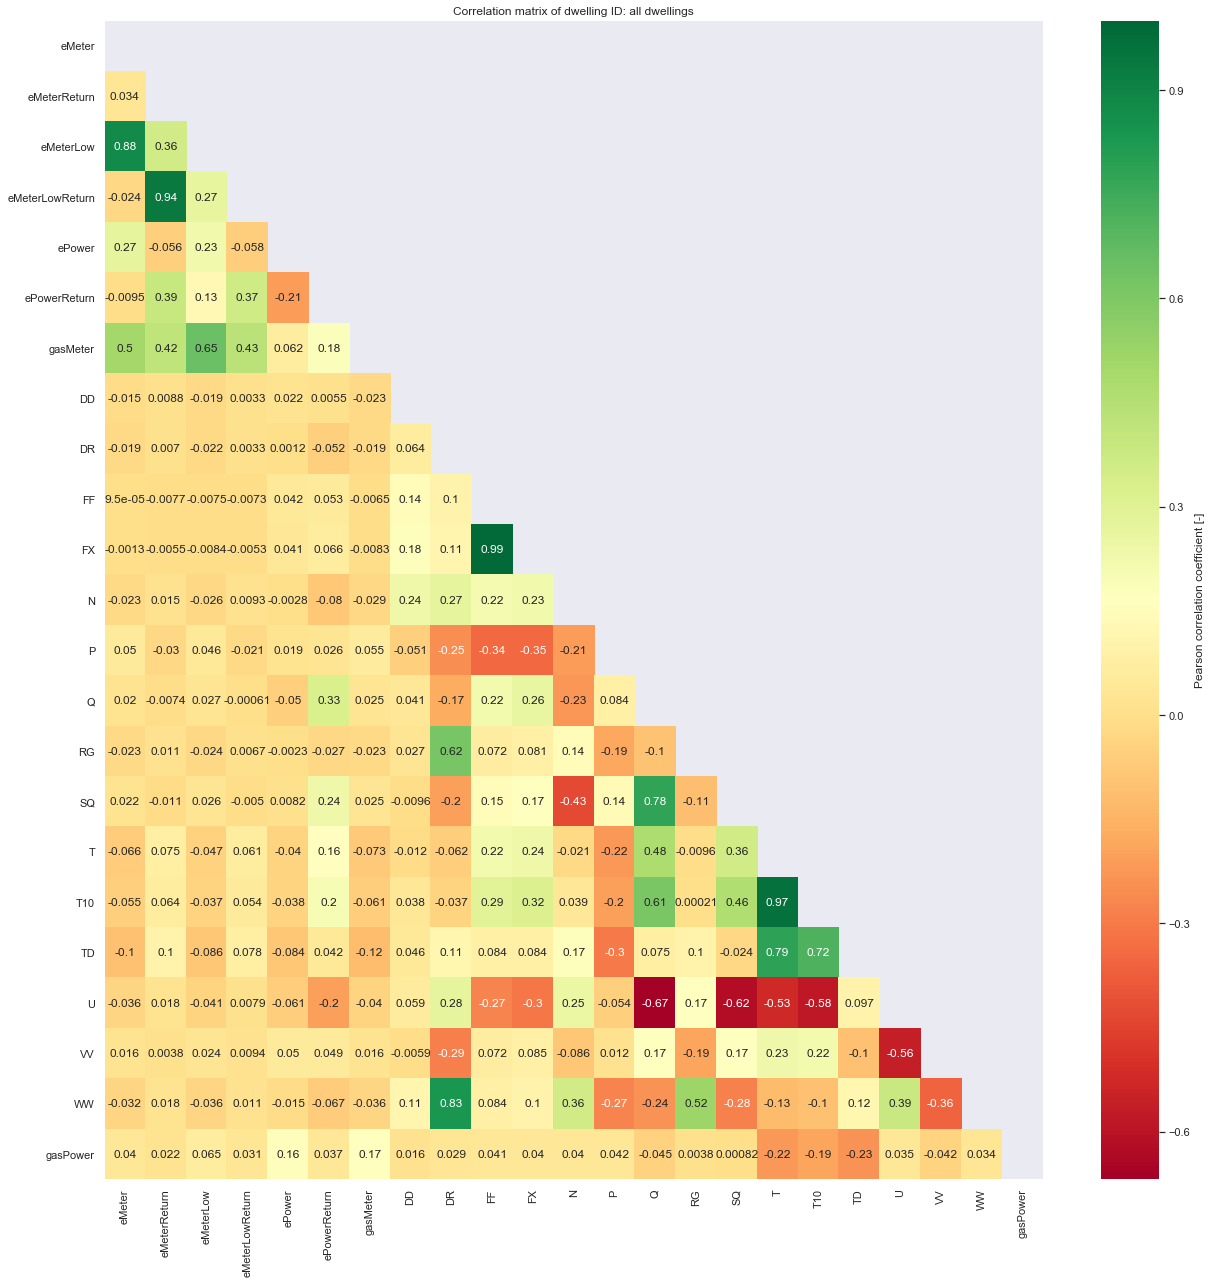

In [16]:
%%time
fig = create_corr_matrix(day, 'all dwellings', True)

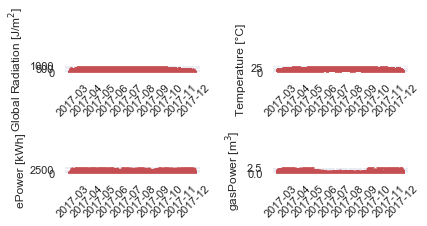

In [17]:
sns.set()

def datetime_layout():
    plt.xticks(rotation=45)
    #plt.grid()
    plt.tight_layout()

x = day.index

plt.subplot(3,2,1)
plt.plot(x, day['Q'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
datetime_layout()

plt.subplot(3,2,2)
plt.plot(x, day['T'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
datetime_layout()

plt.subplot(3,2,3)
plt.plot(x, day['ePower'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
datetime_layout()

plt.subplot(3,2,4)
plt.plot(x, day['gasPower'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
datetime_layout()

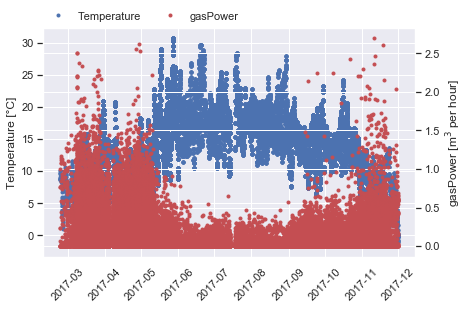

In [18]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['T'], 'b.', linewidth=0.5, label='Temperature')
ax.set_ylabel('Temperature [°C]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r.', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

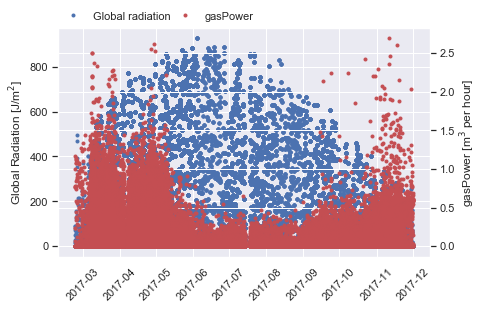

In [19]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['Q'], 'b.', linewidth=0.5, label='Global radiation')
ax.set_ylabel('Global Radiation [J/m$^2$]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r.', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

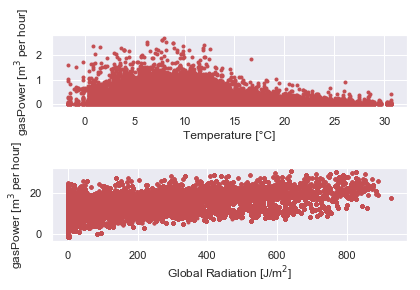

In [20]:
plt.subplot(2,1,1)
plt.plot(day['T'], day['gasPower'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Temperature [°C]')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(day['Q'], day['T'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Global Radiation [J/m$^2$]')
plt.tight_layout()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


AttributeError: module 'seaborn' has no attribute 'plt'

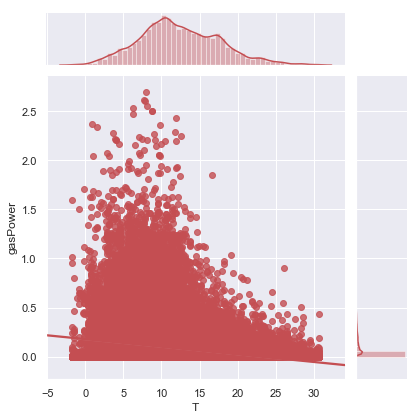

In [21]:
fig = sns.jointplot(x="T", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Temperature [°C]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

In [ ]:
fig = sns.jointplot(x="Q", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Global Radiation [J/m$^2$]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(day['T'], day['Q'], day['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 19?, so deselect this data
data = day[day['T'] < 19]



#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = data[['T', 'Q']]
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data['T'], data['Q'], data['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data['T'], data['Q'], data['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower with more variables

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX', 'dwelling'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['ePower', 'ePowerReturn', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.37882296640675334

In [18]:
model.coef_

array([[  7.99722329e-05,   7.07644067e-05,  -1.42729141e-05,
          3.35764862e-03,  -2.54856306e-04,  -2.25073658e-04,
         -4.71591903e-03,  -1.28480513e-02,  -1.26430983e-04]], dtype=float32)

# Multivariable linear regression: predict ePower

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX', 'dwelling'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['ePower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'gasPower']


0.050187667754420739

In [20]:
model.coef_

array([[ -3.74414511e-02,   7.54543400e+00,  -2.20414543e+00,
         -6.79331049e-02,  -6.17887735e+00,  -2.75610065e+00,
          2.06502527e-01,   2.92018646e+02]], dtype=float32)

# Deep learning
## Initialize tensorflow setup

In [21]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Preprocessing data

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = day[day['T'] < 19]
epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

In [23]:
# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX', 'dwelling'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


In [24]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (833, 8)
X_test shape: (3334, 8)
y_train shape: (833, 1)
y_test shape: (3334, 1)

X_train variance 1.03086965155
y_train variance 0.833491802546


# Create the keras model

In [26]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(8, input_shape=(8,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

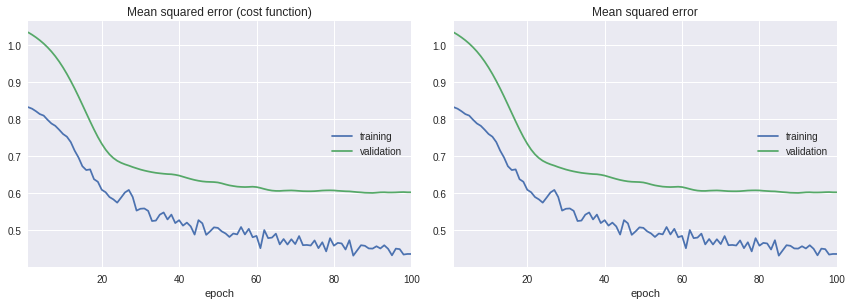

 - 0s - loss: 0.4362 - mean_squared_error: 0.4362 - val_loss: 0.6023 - val_mean_squared_error: 0.6023


In [27]:
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

How to interpret mean squared error:  
`The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.`  
https://en.wikipedia.org/wiki/Mean_squared_error

# Keras on higher resolution data
## Preprocessing data

In [29]:
data = resample_df(df,'1H')
data = data.dropna()

100%|██████████| 52/52 [00:00<00:00, 112.96it/s]


In [30]:
"""
Create columns with time information. 
The idea is that the neural network will start taking time into account also.
"""
data['hour'] = data.index.hour
#data['minute'] = data.index.minute
#data['second'] = data.index.second
data = data.dropna()
data.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.441010,288.200012,0.0,5.418334,...,10.0000,9.116667,10.750000,5.416667,77.166664,23800.000000,2.666667,0.000000,P01S01W7548,16
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.441010,285.866669,0.0,4.593333,...,2.9361,7.866667,8.450000,4.550000,78.833336,22233.333984,1.000000,0.000000,P01S01W7548,17
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.441010,286.633331,0.0,3.783333,...,5.0000,7.066667,6.816667,4.433333,82.833336,20266.666016,2.500000,0.000000,P01S01W7548,18
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.441010,278.783325,0.0,2.741667,...,0.0000,6.616667,6.016667,4.300000,84.666664,17433.333984,2.833333,0.000000,P01S01W7548,19
2017-03-07 20:00:00,626.458984,0.0,359.501007,0.0,499.144440,0.0,307.544006,245.816666,0.0,3.418333,...,0.0000,6.616667,6.183333,3.716667,81.333336,21733.333984,2.000000,0.102997,P01S01W7548,20


In [31]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX', 'dwelling'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'hour']


In [32]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (73806, 9)
X_test shape: (31632, 9)
y_train shape: (73806, 1)
y_test shape: (31632, 1)

X_train variance 0.992670452743
y_train variance 1.00756876205


# Creating the model

In [36]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

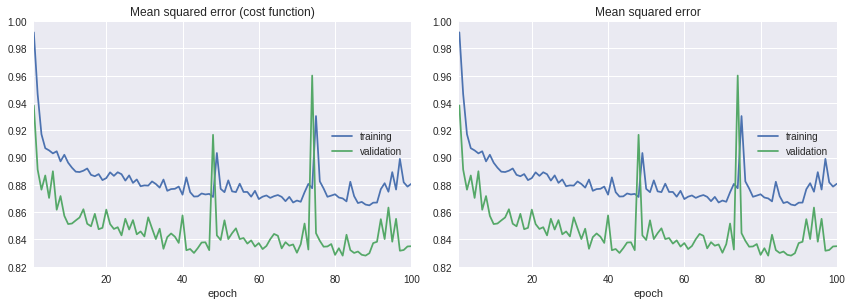

 - 0s - loss: 0.8808 - mean_squared_error: 0.8808 - val_loss: 0.8351 - val_mean_squared_error: 0.8351
CPU times: user 44.7 s, sys: 3.4 s, total: 48.1 s
Wall time: 31.3 s


In [37]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='Nadam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

Higher resolution will give worse results (But why? The hour column is there...)

# Do the same, but to predict energy usage
## Preprocessing

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['ePower']]

X columns: ['DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'gasPower', 'dwelling', 'hour']


In [ ]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

# Create the model

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

In [ ]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=50, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])